# Optimal Portfolio
This notebook construct 3 different optimal portfolios. 1) the minimum variance portfolio, 2) the efficient tangent portfolio (*maximizing simple risk adjusted return*) and 3) the maximum calmar-ratio portfolio (*maximum drawdown adjusted return*).

1. **Minimum variance portfolio**
    This is a portfolio which is constructed using only risk-measures. Risk is perceived as variance, $\sigma_{i}^{2}$ (or volatility) of returns $r_{i}$. The minimum variance portfolio with $N$ assets and their sample covariance matrix $\hat\Sigma$ is found by choosing a weight vector $w$ that minimizes the portfolio volatility,
\begin{equation}
    \arg\min_{w} w'\hat\Sigma w\text{, such that } w'\iota = 1
\end{equation}


2. **Efficient tangent portfolio**
    This portfolio seeks to maximize the risk adjusted return, that is the Sharpe Ratio. This is the portfolio where the trade-off between return and risk is at its optimal level.  
    Here the weight vector, $w$ is chosen such that,
\begin{equation}
    \arg\max_{w} \frac{R_{p}(w)-R_{f}}{\sigma(w)}
\end{equation}


3. **Maximum Calmar Ratio portfolio**
    Variance being a measure of risk has some complications. One complication is that variance doesn't reflect tail risks, which can be quiet significant. The Calmar Ratio is the the maximum drawdown, $\gamma$, (being a proxy for tail-risk) adjusted returns. Thereby the maximum Calmar ratio portfolio seeks to maximize the trade-off between return and tail risks.
    Here the weight vector, $w$ is chosen such that,
\begin{equation}
    \arg\max_{w} \frac{R_{p}(w)-R_{f}}{\gamma(w)}
\end{equation}



where $R_{p}$ denotes the portfolio's annualized return, $R_{f}$ denotes the risk-free interest rate (by default $=0$ in this case. $\sigma_{p}$ denotes the standard deviation of the portfolio. The maximum drawdown is calculated as the maximum $\approx$1 month (21 trading days) drawdown for a given asset or portfolio.

In [1]:
# loading relevant packages
import datetime as dt

# local modules
import pftools
import VaR_and_ES as vares
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

## Loading and cleaning data
In this notebook, data can be fetched using the downloaded CSV-files or using the yahoo database.

In [2]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with file-name
tickers = ['SXR8', 'XACTC25', 'XDJP', 'LCUA' ,'SXRP', 'SXRL', 'XJSE'] # stock and bonds ETFs


# getting data from a local csv-file
df, rdf, cdf = pftools.df_generator(tickers,'csv','Data_Investing_com/')

First observation in dataframe is         04-01-2010
Note that SXR8       first appears at the 28-05-2010
                     This means theres is missing data from the first 0.4 years, corresponding to approximately 99 trading days/observations

Note that XACTC25    first appears at the 08-02-2019
                     This means theres is missing data from the first 9.09 years, corresponding to approximately 2292 trading days/observations

Note that XDJP       first appears at the 07-03-2013
                     This means theres is missing data from the first 3.17 years, corresponding to approximately 798 trading days/observations

Note that LCUA       first appears at the 11-06-2018
                     This means theres is missing data from the first 8.44 years, corresponding to approximately 2125 trading days/observations

Note that XJSE       first appears at the 03-12-2013
                     This means theres is missing data from the first 3.91 years, corresponding to approxi

In [3]:
# pick which tickers to use in the analysis.
# Make sure names are compatible with yahoo database or file-name
tickers = ['FORTUM.HE', 'WM','AMD', 'ASML.AS', 'FB', 'SE', '600887.SS', 'SHOP', 'ST5.DE','SNPS','TTD','ZS','NEPA.ST','EW','ACN','NESTE.HE']
tickers = ['FORTUM.HE', 'WM', 'SE', '600887.SS','SHOP', 'ST5.DE','TTD','NEPA.ST','ACN',]


# enter time period of interest
start = dt.datetime(2014, 6, 30)
end = dt.datetime(2019, 6, 30)

# getting data from yahoo database
df, rdf, cdf = pftools.df_generator(tickers,'yahoo')

No starttime selected, has therefore chosen default closest to (5 years before today) 2016-10-26
No endtime selected, has therefore chosen default which is the latest trading day as of 2021-10-26

First observation in dataframe is         27-10-2016
Note that SE         first appears at the 20-10-2017
                     This means theres is missing data from the first 0.98 years, corresponding to approximately 247 trading days/observations



## Describing each tickers
Now that data is loaded, it's time to get an idea of what we're dealing with.\
The correlation heatmap will give you an idea of the interconnectedness of chosen assets.\
The cummulative returns will leave us with an illustrative idea of the historical performance, both in terms of return but also (yet more vaguely) the variance or drawdown of returns.\
The distribution of returns for each chosen asset will leave us with a more concrete idea of variance and drawdown of returns.\
Lastly there's a table with actual measures of annualized return, volatility, Sharpe ratio, 1 month max draw-down and the Calmar ratio.

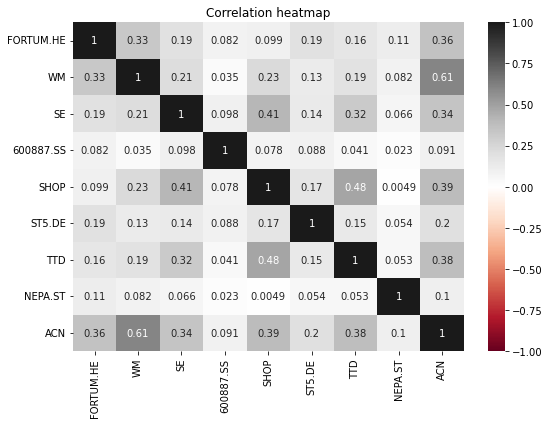

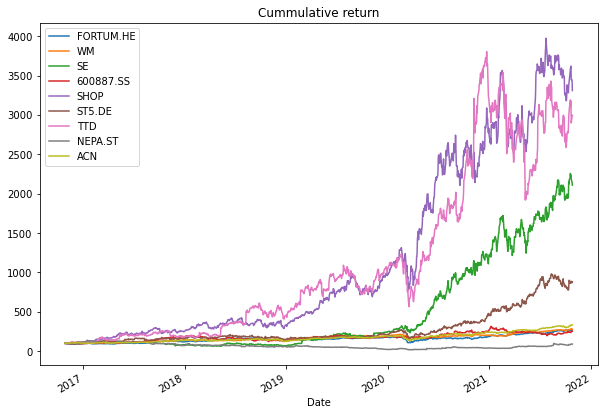

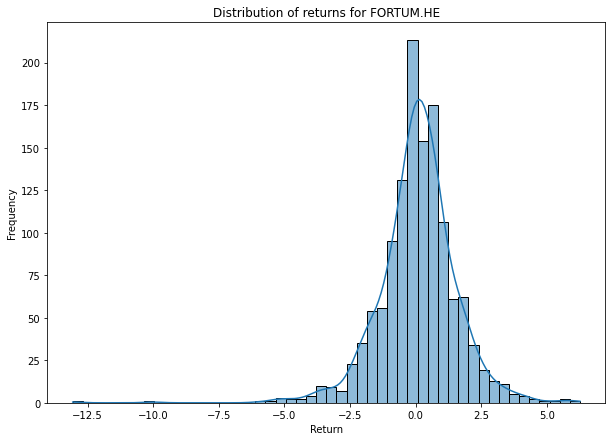

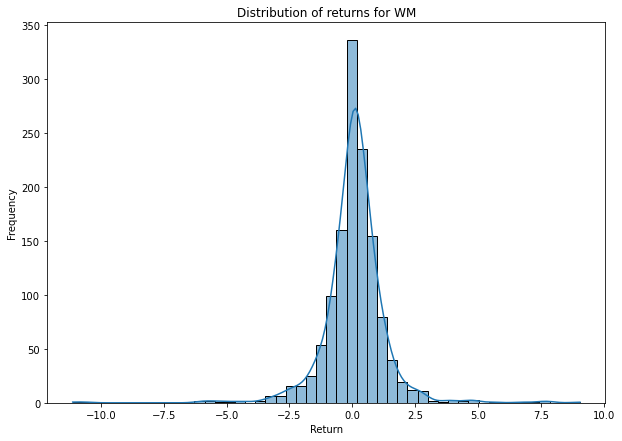

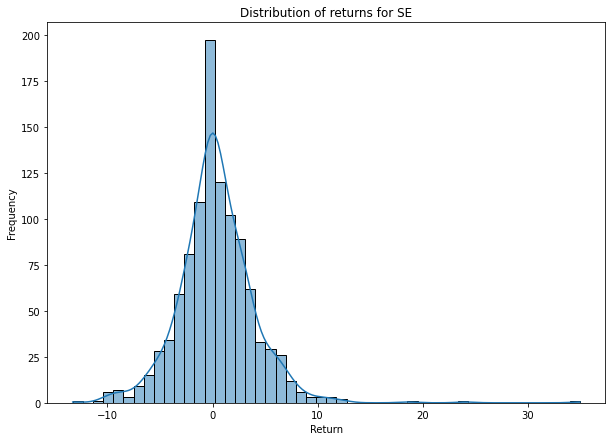

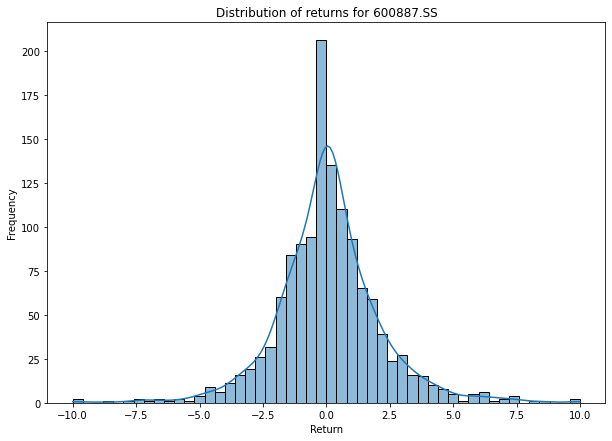

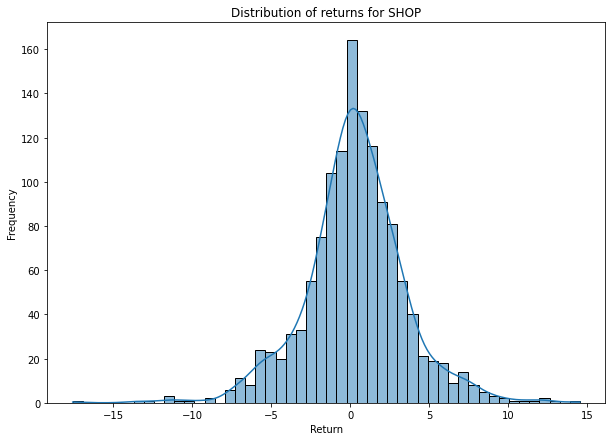

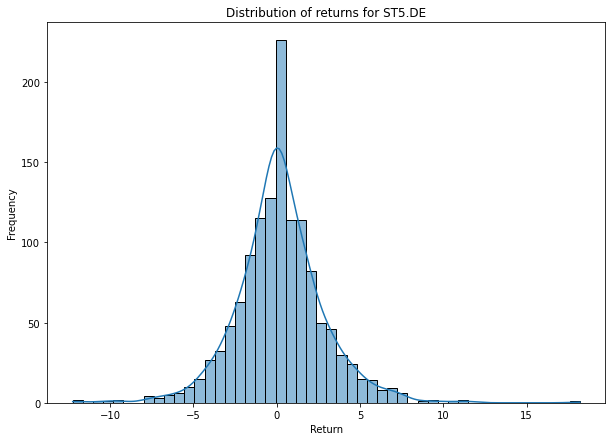

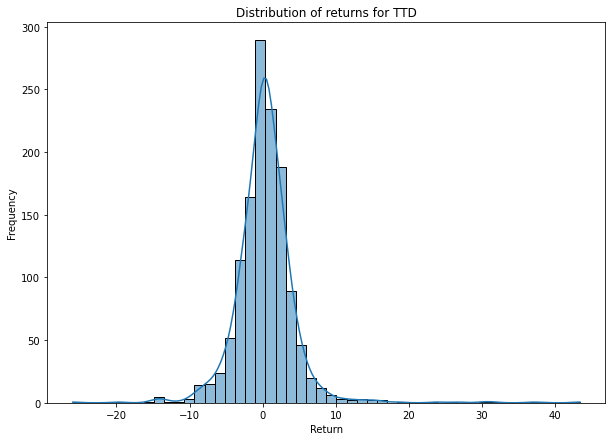

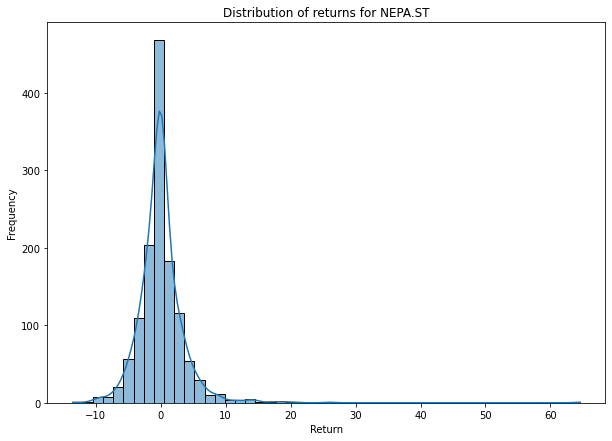

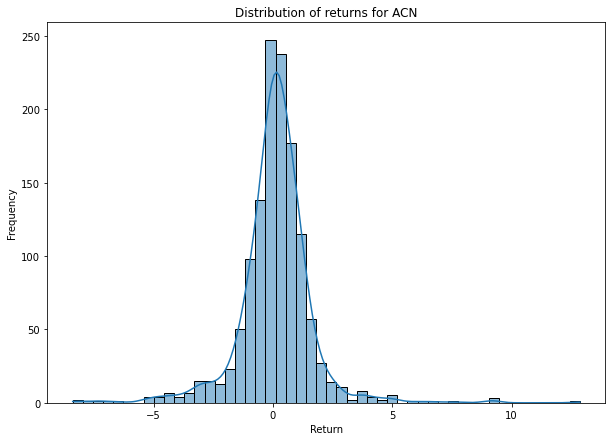

,Annualized return,Volatility,Sharpe ratio,1m max drawdown,Calmar ratio
Ticker,,,,,
FORTUM.HE,21.88,23.64,0.93,40.44,0.54
WM,22.51,20.14,1.12,29.13,0.77
SE,113.51,57.80,1.96,27.62,4.11
600887.SS,20.28,32.69,0.62,20.07,1.01
SHOP,101.35,50.64,2.00,39.33,2.58
ST5.DE,54.51,42.24,1.29,48.59,1.12
TTD,97.38,66.86,1.46,53.19,1.83
NEPA.ST,-2.33,60.19,-0.04,48.80,-0.05
ACN,27.35,24.41,1.12,32.19,0.85


In [4]:
mu = pftools.desc_ticks(df,rdf,cdf)

## Analysing risk for given ticker
Risk management is crucial.\
Both Value-at-Risk (VaR) and Expected Shortfall (ES) are simple measures of the downside risk for an asset (or portfolio)\
\
The $h$-th period VaR is simply the probability, $\alpha\in(0,1)$, that solves, 
\begin{equation}
    P(L_{t,h}>VaR_{t,h}^{\alpha}|I_{t})=\alpha
\end{equation}
where $L_{t,h}$ is the loss between day $t$ and $t+h$. Note that the loss is denoted as the negative payoff, meaning that positive values in the below graphs are actually losses. $\alpha$ denotes the risk level while $I_{t}$ denotes the information set at time $t$, in this case the historical log-returns.\
$VaR_{t,h}^{\alpha}$ can also be regarded as the $1-\alpha$ percentile of the conditional $h$-th period loss distribution. This means that by definition the loss, $L_{t,h}$, will not exceed $VaR_{t,h}^{\alpha}$ with probability $1-\alpha$
While the VaR state the probability of not exceeding some loss, it doesn't state anything about the magnitude of the loss, given that the loss is exceeded. This is where ES comes in.\
\
The $h$-th period ES at risk level $\alpha\in(0,1)$ is given by,
\begin{equation}
    ES_{t,h}^{\alpha}=E[L_{t,h}|L_{t,h}>VaR_{t,h}^{\alpha},I_{t}]
\end{equation}
By definition the ES quantifies the expected loss, given that the loss exceeds the VaR.\
\
In this case we calculate both VaR and ES with log-returns following a gaussian distribution as well as log-returns following an ARCH(1) process for a given asset.

In [5]:
# first the given assets is estimated as an ARCH(1)-model
omega_hat, alpha_hat, ll = vares.ARCH1_est('WM',df)

Estimating WM as a ARCH(1)-model resulted in:
--------------------------------------------------------------------------------------
Omega^hat                       --> 0.7305 with std. errors (0.0302) and t-val 24.1912
alpha^hat                       --> 0.7325 with std. errors (0.0580) and t-val 12.6253
Maximized log-likelihood        --> -1535.260
--------------------------------------------------------------------------------------


Risk measures for WM at 1 period losses with a 0.05 risk level is
-----------------------------------------
Gauss
-----
VaR                             --> 2.09
ES                              --> 2.62
-----------------------------------------
ARCH(1)
------
VaR (average)                   --> 1.95
ES  (average)                   --> 2.45
-----------------------------------------


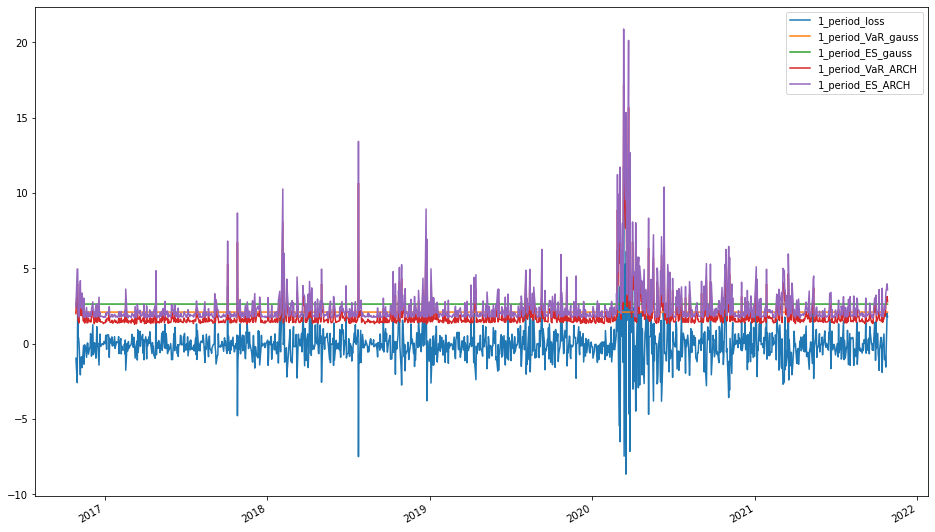

In [6]:
# then the VaR and ES is calculated using gaussian returns and the ARCH(1) estimates for given asset
vares_df = vares.VaRES(omega_hat,alpha_hat,df,'WM',0.05,1,2000)
vares_df.plot(figsize = (16,10));

The above risk measures can be combined with OTM-put options in order to hedge against drawdowns. This is especially important when portfolio is concentrated around a few assets

## Solving the optimal portfolios

In [7]:
pftools.ana_optimal_portfolios(df,rdf,mu)

-----------------------------------------------------------------------------------------------

The analytical solution for the minimum variance portfolio (allows for shorting) resulted in:



,weight
Ticker,
FORTUM.HE,24.37
WM,41.59
SE,-1.93
600887.SS,18.70
SHOP,2.90
ST5.DE,5.94
TTD,-0.76
NEPA.ST,3.79
ACN,5.40


With portfolio characteristics:



,stats
Annualized return,23.12
Volatility,15.40
Sharpe ratio,1.50
1m max drawdown,29.08
Calmar ratio,0.79


-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------

The analytical solution for the efficient tangent portfolio (allows for shorting) resulted in:



,weight
Ticker,
FORTUM.HE,15.32
WM,33.64
SE,21.14
600887.SS,10.28
SHOP,23.94
ST5.DE,19.86
TTD,6.85
NEPA.ST,-3.91
ACN,-27.12


With portfolio characteristics:



,stats
Annualized return,71.43
Volatility,27.06
Sharpe ratio,2.64
1m max drawdown,36.67
Calmar ratio,1.95


-----------------------------------------------------------------------------------------------

Cannot analytically solve the maximum calmar ratio portfolio


In [8]:
import warnings
warnings.filterwarnings('ignore') # theres a bug in scipy 1.6 which throws runtime warnings at you. This suppress' it
smvw, stw, scw = pftools.num_optimal_portfolios(df,mu,50,True)
warnings.filterwarnings('default')

SHORTING IS ALLOWED
-------------------------------------------------------
Will numerically solve the minimum variance portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 5 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,24.37
WM,41.59
SE,-1.93
600887.SS,18.70
SHOP,2.90
ST5.DE,5.94
TTD,-0.76
NEPA.ST,3.79
ACN,5.40


With portfolio characteristics:


,stats
Annualized return,23.12
Volatility,15.40
Sharpe ratio,1.50
1m max drawdown,29.08
Calmar ratio,0.79


-------------------------------------------------------
Will numerically solve the efficient tangent portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 5 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,15.32
WM,33.63
SE,21.14
600887.SS,10.29
SHOP,23.94
ST5.DE,19.86
TTD,6.85
NEPA.ST,-3.91
ACN,-27.11


With portfolio characteristics:


,stats
Annualized return,71.43
Volatility,27.06
Sharpe ratio,2.64
1m max drawdown,36.67
Calmar ratio,1.95


Currently no numerical solution for maximum calmar ratio portfolio with shorting - will therefore be solved for
SHORTING IS NOT ALLOWED
-------------------------------------------------------
Will numerically solve the calmar portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 3 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,0.0
WM,0.0
SE,100.0
600887.SS,0.0
SHOP,0.0
ST5.DE,0.0
TTD,0.0
NEPA.ST,0.0
ACN,0.0


With portfolio characteristics:


,stats
Annualized return,113.51
Volatility,57.80
Sharpe ratio,1.96
1m max drawdown,27.62
Calmar ratio,4.11


In [9]:
warnings.filterwarnings('ignore')
mvw, tw, cw = pftools.num_optimal_portfolios(df,mu,50,False)
warnings.filterwarnings('default')

SHORTING IS NOT ALLOWED
-------------------------------------------------------
Will numerically solve the minimum variance portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 3 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,23.96
WM,42.02
SE,0.00
600887.SS,18.65
SHOP,1.79
ST5.DE,5.86
TTD,0.00
NEPA.ST,3.72
ACN,3.99


With portfolio characteristics:


,stats
Annualized return,24.50
Volatility,15.44
Sharpe ratio,1.59
1m max drawdown,29.04
Calmar ratio,0.84


-------------------------------------------------------
Will numerically solve the efficient tangent portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 3 times
The improvements of the optimal solution resulted in a deviation of allocation of more than 1 pct. for at least 1 asset.
All optimal solution are as follows:
----------------------
Attempt 0 had weights: [10. 17. 19.  9. 22. 18.  5.  0.  0.] with Sharpe Ratio = 2.59

Attempt 5 had weights: [11. 17. 19.  9. 22. 18.  5.  0.  0.] with Sharpe Ratio = 2.59

Attempt 29 had weights: [10. 17. 19.  9. 22. 18.  5.  0.  0.] with Sharpe Ratio = 2.59

----------------------

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,10.47
WM,16.92
SE,18.80
600887.SS,9.19
SHOP,21.65
ST5.DE,18.10
TTD,4.86
NEPA.ST,0.00
ACN,0.00


With portfolio characteristics:


,stats
Annualized return,65.84
Volatility,25.45
Sharpe ratio,2.59
1m max drawdown,35.17
Calmar ratio,1.87


-------------------------------------------------------
Will numerically solve the calmar portfolio
Multistart optimization
-------------------------------------------------------
Performed multistart optimization with N = 50 total attempts
The optimal solution improved 1 times
The improvements of the optimal solution resulted in no notable deviations of allocation.

The optimal portfolio allocation ended up being:


,weight
Ticker,
FORTUM.HE,0.0
WM,0.0
SE,100.0
600887.SS,0.0
SHOP,0.0
ST5.DE,0.0
TTD,0.0
NEPA.ST,0.0
ACN,0.0


With portfolio characteristics:


,stats
Annualized return,113.51
Volatility,57.80
Sharpe ratio,1.96
1m max drawdown,27.62
Calmar ratio,4.11


## Simulating 3 month portfolio return for given allocation $w$

Simulating 1000 timeseries for each type of portfolio where shorting is allowed
--------------------------------------------------------------------------------

Simulates the minimum variance portfolio 1000 times over 63 days


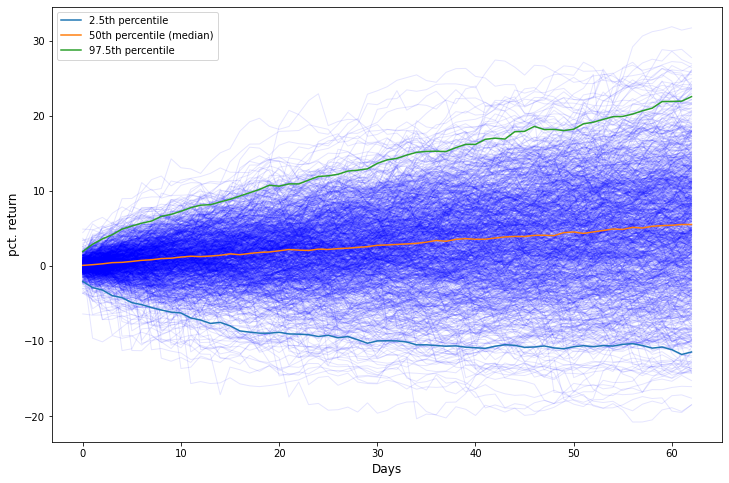

----------------------------------------------------------------------------------------------------

Simulates the efficient tangent portfolio 1000 times over 63 days


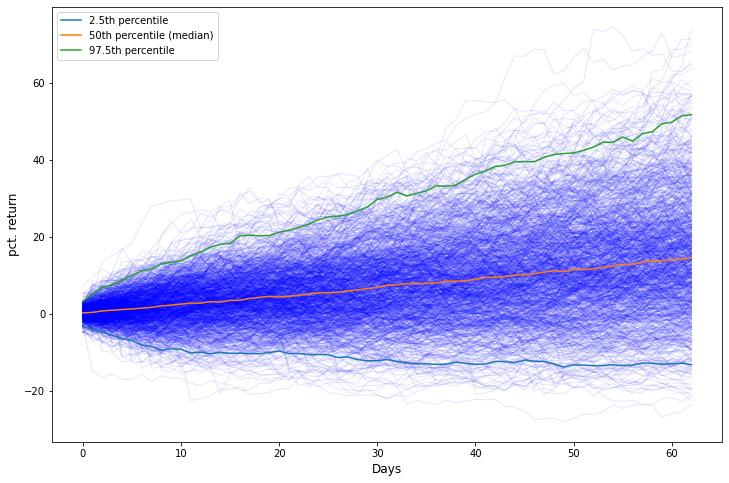

----------------------------------------------------------------------------------------------------
Simulates the optimal calmar ratio portfolio (shorting is not allowed) 1000 times over 63 days


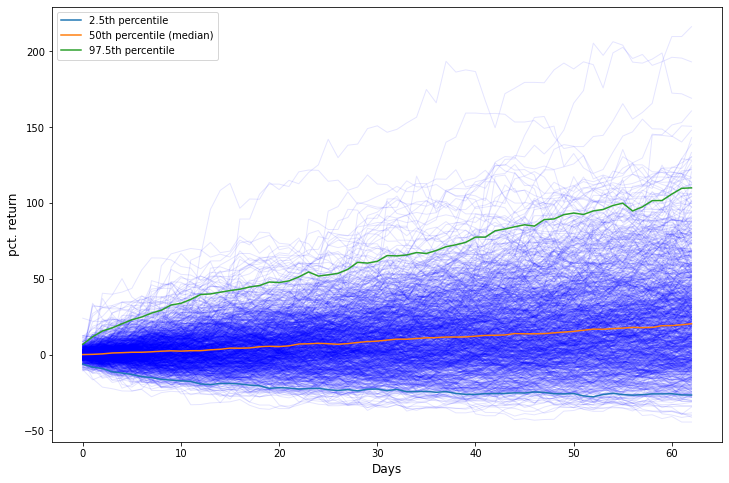

In [10]:
pftools.simulated_portfolios(smvw, stw, scw, rdf, N = 1000, t = 63, shorting = True)

Simulating 1000 timeseries for each type of portfolio where shorting is NOT allowed
--------------------------------------------------------------------------------

Simulates the minimum variance portfolio 1000 times over 63 days


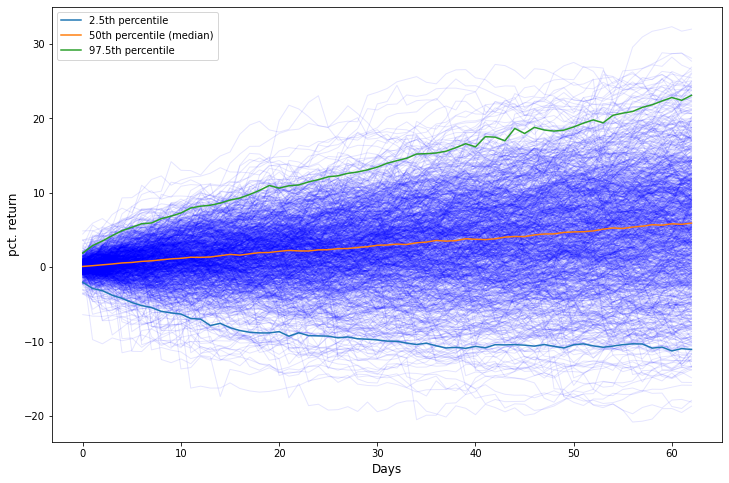

----------------------------------------------------------------------------------------------------

Simulates the efficient tangent portfolio 1000 times over 63 days


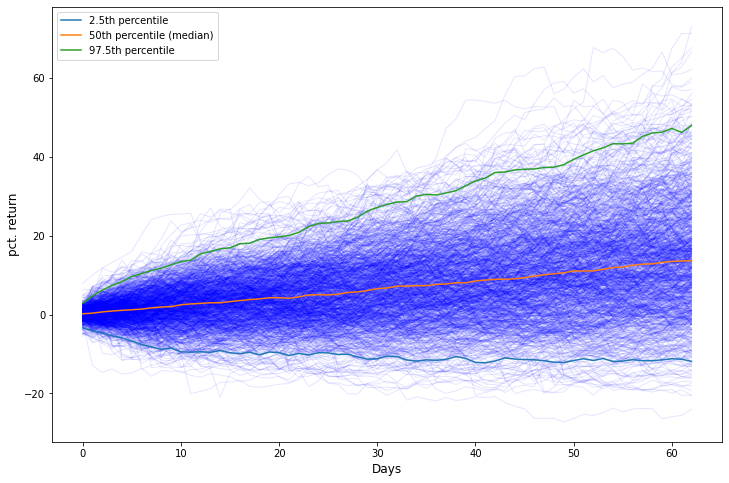

----------------------------------------------------------------------------------------------------
Simulates the optimal calmar ratio portfolio (shorting is not allowed) 1000 times over 63 days


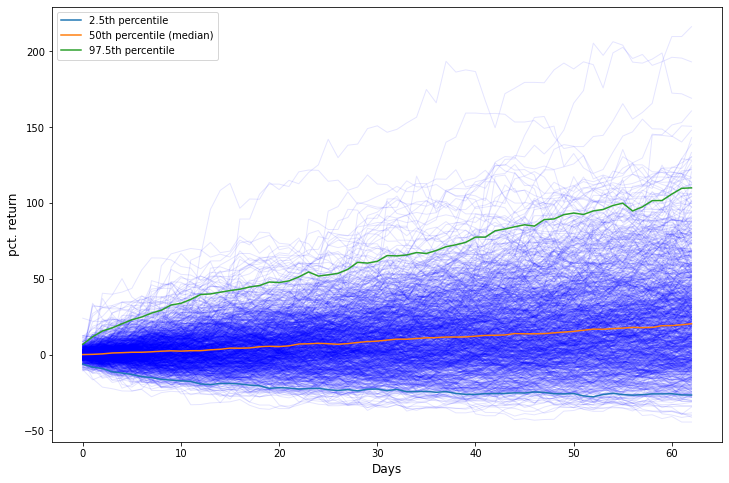

In [11]:
pftools.simulated_portfolios(mvw, tw, cw, rdf, N = 1000, t = 63)